### 1. IMPORT PACKAGES

In [95]:
#!pip install pandas numpy yfinance matplotlib
#!pip install scikit-learn
#!pip install torch

In [96]:
# Data Preprocessing
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn


### 2. DATASET

In [97]:
# Set the start and end dates
start_date = '2020-01-01'
end_date = '2020-12-31'

# Download TSLA data
tsla_price_df = yf.download('TSLA', start=start_date, end=end_date)
tsla_price_df.index = pd.to_datetime(tsla_price_df.index)

# Split the dataset into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(tsla_price_df, test_size=0.2, shuffle=False)


[*********************100%***********************]  1 of 1 completed


In [98]:
tsla_price_df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2020-01-02 00:00:00+00:00,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03 00:00:00+00:00,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06 00:00:00+00:00,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07 00:00:00+00:00,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08 00:00:00+00:00,32.809334,32.809334,33.232666,31.215334,31.580000,467164500


In [76]:
tsla_price_df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2020-12-23 00:00:00+00:00,215.326660,215.326660,217.166672,207.523331,210.733337,99519000
2020-12-24 00:00:00+00:00,220.589996,220.589996,222.029999,213.666672,214.330002,68596800
2020-12-28 00:00:00+00:00,221.229996,221.229996,227.133331,220.266663,224.836670,96835800
2020-12-29 00:00:00+00:00,221.996674,221.996674,223.300003,218.333328,220.333328,68732400
2020-12-30 00:00:00+00:00,231.593338,231.593338,232.199997,222.786667,224.000000,128538000


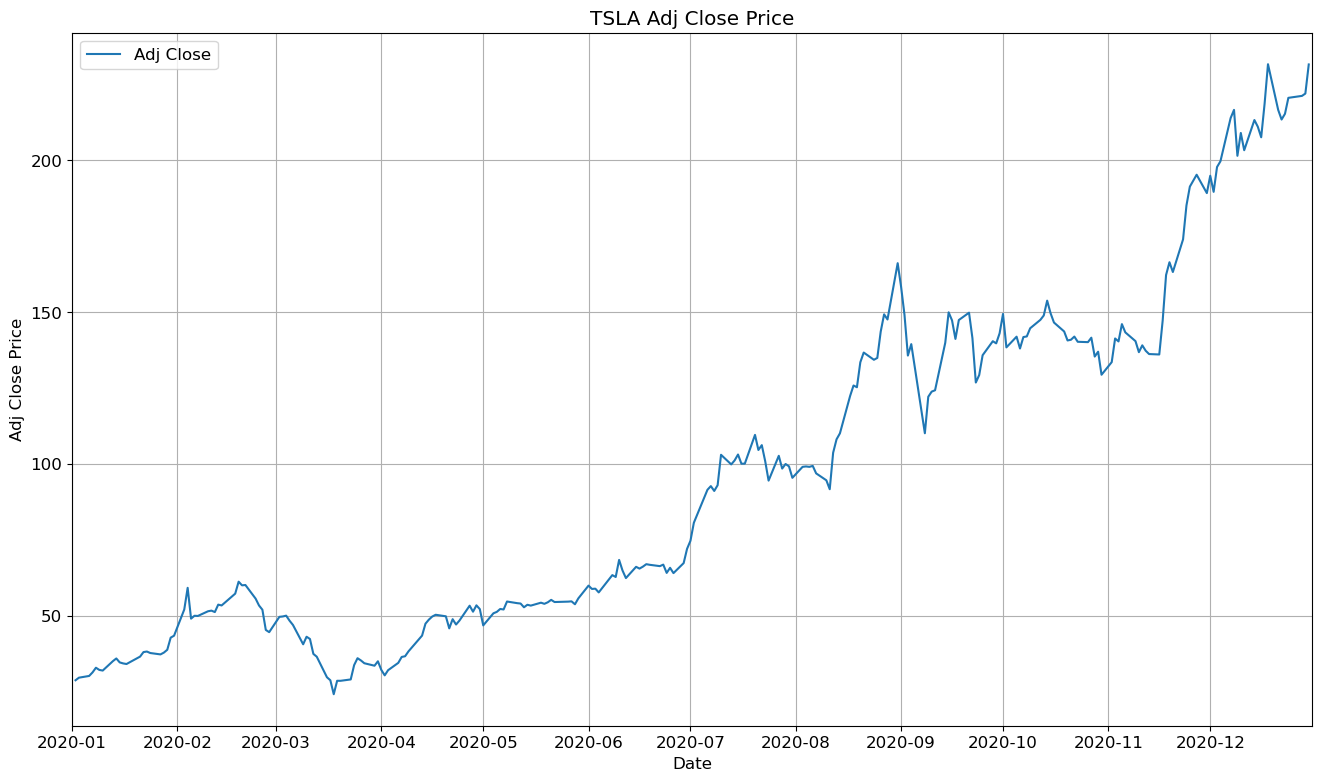

In [102]:
start_time_all = datetime.datetime(2020, 1, 1) # 2020-01-01
end_time_train = datetime.datetime(2020, 9, 30) # 2020-09-30
start_time_val = datetime.datetime(2020, 10, 1) # 2020-10-01
end_time_all = datetime.datetime(2020, 12, 31) # 2020-12-31

# Features variables (Close price, High price, Low price, Open price, Volume)
X = tsla_price_df.iloc[:, 1:6]

# Traget variable (Adj Close price)
y = tsla_price_df.iloc[:, 0:1]

# TSLA Adj Close price from 2020-01-01 to 2020-12-31
plt.plot(tsla_price_df.index, y, label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('TSLA Adj Close Price')
plt.legend()
plt.show()

### 3. Normalizing and converting data

In [103]:
# Normalize the features (Close, High, Low, Open, Volume)
features = ['Close', 'High', 'Low', 'Open', 'Volume']
scaler_features = MinMaxScaler()
train_features = scaler_features.fit_transform(train_df[features])
test_features = scaler_features.transform(test_df[features])

# Create a new DataFrame with the normalized features
train_features_df = pd.DataFrame(train_features, columns=features, index=train_df.index)
test_features_df = pd.DataFrame(test_features, columns=features, index=test_df.index)

# Normalize the target column ('Adj Close') separately
scaler_target = MinMaxScaler(feature_range=(0, 1))
train_target = scaler_target.fit_transform(train_df[['Adj Close']].values)
test_target = scaler_target.transform(test_df[['Adj Close']].values)

# Print the first records of normalized data and the dimensions of the tensors
print("First records of normalized data (features):")
print(train_features_df.head())

print("\nFirst records of normalized data (target):")
print(train_target[:5])

First records of normalized data (features):
                              Close      High       Low      Open    Volume
Date                                                                       
2020-01-02 00:00:00+00:00  0.032407  0.012260  0.035564  0.023315  0.081876
2020-01-03 00:00:00+00:00  0.038392  0.023316  0.043161  0.030805  0.229156
2020-01-06 00:00:00+00:00  0.042396  0.022158  0.044699  0.030791  0.092608
2020-01-07 00:00:00+00:00  0.050620  0.031681  0.051373  0.040590  0.231007
2020-01-08 00:00:00+00:00  0.061454  0.044425  0.058800  0.046348  0.467870

First records of normalized data (target):
[[0.03240736]
 [0.03839221]
 [0.04239619]
 [0.05062007]
 [0.06145383]]


In [105]:
# Function to create data sequences for the LSTM model
def create_sequences(data, seq_length=60):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Set the sequence length
seq_length = 30
X_train, y_train = create_sequences(train_target, seq_length)
X_test, y_test = create_sequences(test_target, seq_length)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"\nDimensions of the data for the LSTM model:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Dimensions of the data for the LSTM model:
X_train shape: torch.Size([171, 30, 1])
y_train shape: torch.Size([171, 1])
X_test shape: torch.Size([21, 30, 1])
y_test shape: torch.Size([21, 1])


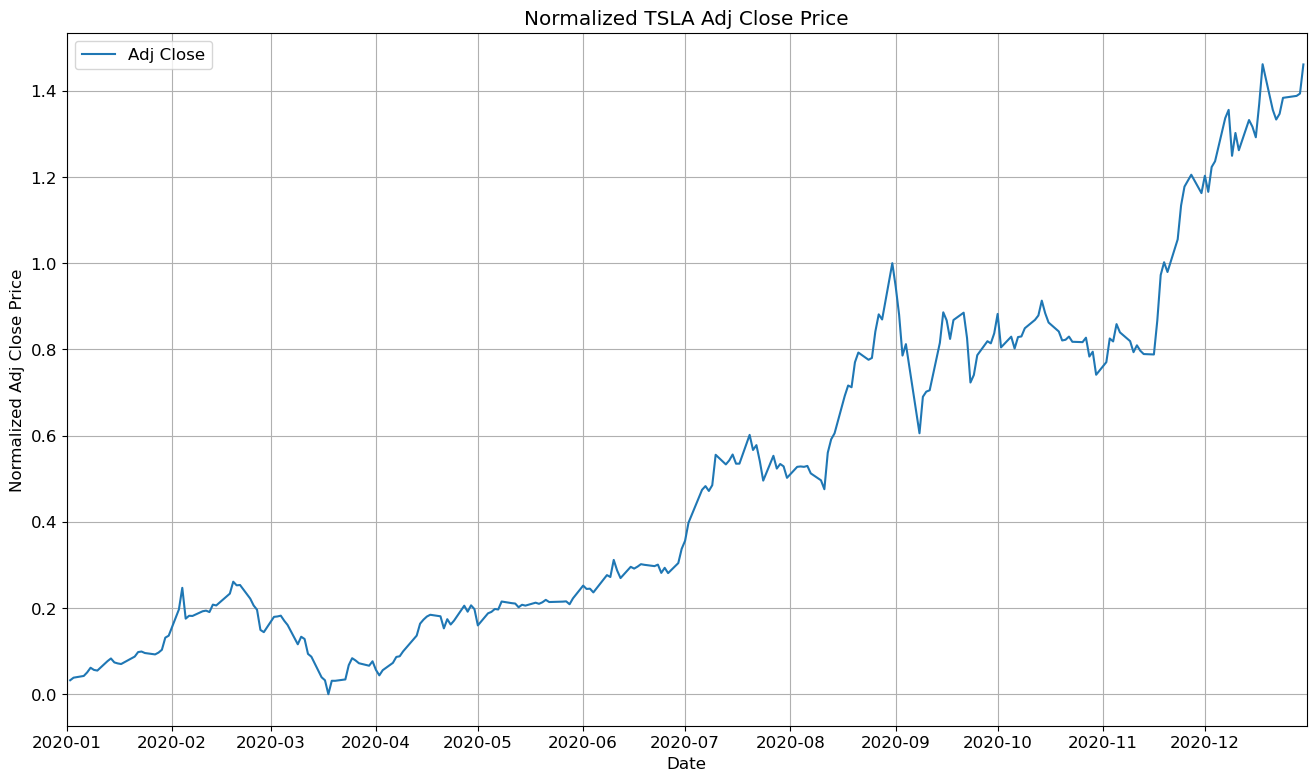

In [106]:
# Graficar la serie de tiempo de Adj Close normalizada
plt.plot(tsla_price_df.index, scaler_target.transform(tsla_price_df[['Adj Close']]), label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Normalized Adj Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('Normalized TSLA Adj Close Price')
plt.legend()
plt.show()